<a href="https://colab.research.google.com/github/justinballas/Finance-Projects/blob/main/Ratios_Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ffn

In [27]:
import numpy as np
import pandas as pd
import requests
import datetime as dt
import ffn
%matplotlib inline

In [3]:
def quarter(date):

  '''
  This function takes in a series of dates, then converts them to month and day
  values, to be converted into fiscal quarters.
  '''

  date=date.strftime('%m-%d')

  if date >='01-01' and date <= '03-31':
    return 'Q1'
  elif date >= '04-01' and date <= '06-31':
    return 'Q2'
  elif date >= '07-01' and date <= '09-30':
    return 'Q3'
  else:
    return 'Q4'

In [5]:
df = pd.read_excel('SP500 Financial Statements v2.xlsx')
#preparing the data as it is returned from the CSV
statements_df = df.set_index('symbol')

hist_df = pd.read_excel('SP500 historical Prices.xlsx')
hist_df['symbol'].ffill(inplace=True)

#Merge adjusted close column to statements_df

#converting the items in the date column into datetime objects
hist_df['date'] = [dt.datetime.strptime(date, "%Y-%m-%d") for date in hist_df['date']]

#creting the period column
hist_df['period'] = hist_df['date'].apply(quarter)

#appending the period and date column to be combined with symbol in order to create a multi index
hist_df.reset_index(inplace=True)
hist_df['year'] = [hist_df['date'][i].strftime("%Y") for i in range(len(hist_df['period']))]

#setting the multi index
hist_df.set_index(['symbol', 'year', 'period'], inplace=True)

beg_df = hist_df[~hist_df.index.duplicated(keep='last')]['adjClose']
end_df = hist_df[~hist_df.index.duplicated(keep='first')]['adjClose']
diff_df = end_df - beg_df

statements_df.reset_index(inplace=True)
statements_df.set_index(['symbol','year','period'], drop=True, inplace=True)

In [6]:
#columns that I want to rank by 'pe_ratio', 'ROE', 'Operating Margin', 'EV/EBITDA'
rank_df = statements_df.loc[slice(None), 2016, 'Q4']

rank_df = rank_df[~rank_df.index.duplicated(keep='first')]

ROE_rank = rank_df[rank_df['ROE']>0]['ROE'].rank(pct=True)
OM_rank = rank_df[rank_df['Operating Margin']>0]['Operating Margin'].rank(pct=True, ascending=False)
EV_EBITDA_rank = rank_df[rank_df['EV/EBITDA']>0]['EV/EBITDA'].rank(pct=True)
PE_rank = rank_df[rank_df['pe_ratio']>0]['pe_ratio'].rank(pct=True)

total_rank = PE_rank + ROE_rank + OM_rank + EV_EBITDA_rank
#total_rank.sort_values().loc[slice(None), '2020.0', 'Q4']

portfolio = list(total_rank.sort_values().head(30).index)
print(portfolio)

['BEN', 'RE', 'TROW', 'GILD', 'GLW', 'PPL', 'DISCK', 'DISCA', 'INTC', 'KSU', 'AMGN', 'SWKS', 'BLK', 'IPGP', 'ORCL', 'VNO', 'CSCO', 'EBAY', 'NSC', 'JNPR', 'IVZ', 'UNP', 'ADI', 'CSX', 'APH', 'CTXS', 'QCOM', 'ES', 'EIX', 'PHM']


In [9]:
portfolio_data = rank_df.loc[portfolio, ['ROE', 'Operating Margin', 'EV/EBITDA', 'pe_ratio']]

In [7]:
hist_df_date = hist_df.reset_index().set_index('date')

In [8]:
for symbol in enumerate(portfolio):
  temp_df = hist_df_date[hist_df_date['symbol']==symbol[1]]['adjClose']
  if symbol[0] == 0:
    portfolio_return = temp_df
  else:
    portfolio_return += temp_df
  

In [10]:
API_KEY = 'c1d0593c7e77101920a7c89dac5a06f4'
years = 5
end_date = dt.datetime.now().date()
delta = dt.timedelta(days=365 * years+1)
start_date = end_date - delta
benchmark_symb = 'SPY'

benchmark_df = requests.get('https://financialmodelingprep.com/api/v3/historical-price-full/'+
                       '{}?from={}&to={}&apikey={}'.format(benchmark_symb, start_date, end_date, API_KEY))
benchmark_df = pd.DataFrame(benchmark_df.json()['historical'])

benchmark_df.set_index('date', inplace=True)

benchmark_df = benchmark_df.loc[:'2016-08-31']

portfolio_return_df = portfolio_return.loc[:'2016-08-31']

compare_df = pd.merge(portfolio_return_df, benchmark_df, how='left', left_index=True, right_index=True)

compare_df.rename(columns={'adjClose_x':'Portfolio', 'adjClose_y':'Benchmark'},inplace=True)

compare_df = compare_df[['Portfolio', 'Benchmark']]

compare_df.sort_index().rebase().plot()

In [69]:
ratio_list = [ROE_rank, OM_rank, EV_EBITDA_rank, PE_rank]

def test_best_ratio(ratio_list):
  pct_change = {}
  portfolio = {}
  for ratio in ratio_list:
    selection = ratio.sort_values()[:30].index
    for symbol in enumerate(selection):
      temp_df = hist_df_date[hist_df_date['symbol']==symbol[1]]['adjClose']
      if symbol[0] == 0:
        portfolio_return = temp_df
      else:
        portfolio_return += temp_df
    pct_change[ratio.name] = (portfolio_return[1] - portfolio_return[-1]) / portfolio_return[1]
    portfolio[ratio.name] = portfolio_return

  return pct_change, portfolio


In [71]:
pct_change, portfolios = test_best_ratio(ratio_list)

In [76]:
portfolio_return = portfolios['EV/EBITDA']

In [77]:
compare_df = pd.merge(portfolio_return, benchmark_df['adjClose'], how='inner', left_index=True, right_index=True, suffixes=('_portfolio', '_benchmark'))

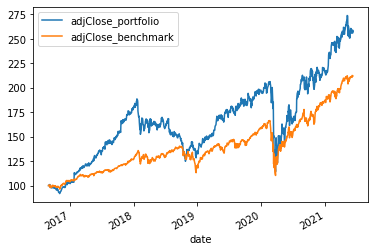

In [79]:
compare_df.sort_index().rebase().plot()